#  Podstawy Aproksymacji (część II): Deep Learning


##  Projekt: Rozpoznawanie ras psów z wykorzystaniem biblioteki Keras.

### Temat został opracowany przez:
### Michał Foryt - nr indeksu: 84172, adres e-mail: mf84172@student.sgh.waw.pl
### Szczepan Gabiec - nr indeksu: 101697, adres e-mail: sg101697@student.sgh.waw.pl
### Paweł Wróblewski - nr indeksu: 78793, adres e-mail: pw78793@student.sgh.waw.pl

<img src="meme2.jpg" style="width: 400px;">

## Wprowadzenie

Celem projektu jest stworzenie algorytmu służącego do rozpoznawaniu ras psów porzy wykorzystaniu biblioteki Keras, w oparciu o TensorFlow. Zbiór z którego korzystaliśmy pochodzi z jednego z konkursów zorganizowanych przez portal Kaggle i znajduje się pod tym linkiem: https://www.kaggle.com/c/dog-breed-identification. Z uwagi na jego rozmiar (~750MB) nie bedzie on dołączony bezpośrednio do kodu.  

W skład zbioru wchodzi około 10 tysięcy zdjęć, a wśród nich można wyróźnić 120 klas (ras psów). Pracując na tych danych, będziemy mogli stworzyć algorytm bazujący na głębokim uczeniu sieci neuronowych. W dużym uproszczeniu, zadaniem tego typu algorytmu jest rozpoznawanie obrazów podobnie, jak robi to umysł ludzki - "oglądając" ogromną pulę zdjęć z czasem rozpoznaje charakterystyczne cechy dla danego obiektu, przykładowo że rottweilera można poznać po tym, że jest duży i ma krótką, ciemną sierść, a york ma krótkie łapy i jest mocno owłosiony. Innymi słowy, algorytm najpierw zbiera dużą ilość danych, a następnie pozwala komputerowi zapoznać się z każdym z nich. Opierając się na dużych bazach danych i zauważając pojawiające się wzorce, komputery mogą rozpoznać obrazy i sformułować odpowiednie tagi i kategorie.



## Konwolucyjne Sieci Neuronowe 
Konwolucyjne Sieci Neuronowe (ang. <i>CNN, Convolutional neural networks</i>, tłumaczone także jako <i>Splotowe Sieci Neuronowe</i>) w sprytny sposób redukują liczbę przyjmowanych parametrów. Kluczem do sukcesu konwolucyjnych sieci jest fakt, że wychodza one z założenia, że wystarczy lokalne zrozumienie obrazu. Innymi słowy, algorytm skupia się na tym, by  stopniowo filtrować różne części danych uczących i wyostrzać ważne cechy w procesie dyskryminacji wykorzystanym do rozpoznawania lub klasyfikacji wzorców. W praktyce zaletą takiego podejścia jest posiadanie mniejszej liczby parametrów, co przekłada się na znaczne zmniejszenie czasu potrzebnego do wytrenowania modelu.

Rozważmy obraz o wymiarze 256 × 256 pikseli. Zamiast przetwarzać cały obraz naraz, CNN może skutecznie skanować go po kawałku - powiedzmy, patrząc na fragment o wymiarach 5 × 5. Taka ramka o wymiarach 5 × 5px przesuwa się wzdłuż obrazu (zwykle od lewej do prawej i od góry do dołu), jak pokazano na poniższym rysunku. 

<img src="cnn_concept.jpeg" style="width: 350px;">

Tempo przesuwania się takiej ramki nazywamy "długością kroku". Na przykład długość kroku 2 oznacza, że okno 5 × 5 przesuwa się o 2 piksele na raz, aż obejmie cały obraz. Taka ramka 5 x 5 pikseli przekłada się na macierz wag o wymiarze 5 x 5. 

Tego typu operacja ma miejsce w warstwie konwolucyjnej sieci. Typowa CNN posiada wiele tego typu warstw. Każda z nich zazwyczaj generuje wiele różnych splotów (ang. <i>convolutions</i>). Co za tym idzie, macierz wagowa takiego tensora (czyli obiektu matematycznego będącego uogólnieniem pojęcia wektora) ma wymiary 5 × 5 x n, gdzie n liczbą konwolucji (splotów).

Przykładowo, załóżmy że przepuszczamy rozważany obraz przez pojedynczą warstwę splotu jako macierz wagowa 5 x 5 x 64 z ramką 5 x 5. Co za ty idzie, taki model posiada 5 x 5 x 64 = 1600 parametrów, podczas gdy pełna sieć dla obrazu 256 x 256 px wymagałaby zastosowania 65 536 parametrów.

## Przetworzenie zbioru danych
Jak już wspomnielismy na początku, wykorzystamy zbiór danych dotyczący rozpoznawania ras psów, który wstępnie został już podzielony na zbiór treningowy i testowy. Nazwa każdego z obrazów jest też jednocześnie jego unikalnym id. Cały zestaw danych zawiera zdjęcia 120 ras. Początkowo zamysłem tego projektu było rozpoznawanie wszystkich z nich, jednak w trakcie pracy nad modelem okazało się, że w domowych warunkach oraz mając ograniczony czas (z uwagi na termin oddania zadania), problem ten będzie zbyt skomplikowany - po tygodniu pracy udało nam się osiągnąć accuracy na poziomie maksymalnie 7%. Z tego względu dla uproszczenia modelu przyjmiemy założenie, że ograniczamy się jedynie do rozpoznawania 4 najpopularniejszych ras. 

Dla porządku, wszystkie niezbędne importy zastosujemy poniżej. Dzięki temu uzyskamy większa czytelność oraz podcas tworzenia naszej funkcjonalności będziemy mieli pewność, że wszystkie niezbędne paczki zostały już ściągnięte.  

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import os
import matplotlib.pyplot as plt
from shutil import copyfile
import tensorflow as tf
from tensorflow import keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import os
import cv2
import pandas as pd

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from collections import Counter

Czytamy dane z pliku labels, które mapują id zdjęcia z jego opisem na zbiorze treningowym. 

In [3]:
labels = pd.read_csv('labels.csv')
labels_dict = {i:j for i,j in zip(labels['id'],labels['breed'])}
classes = set(labels_dict.values())
images = [f for f in os.listdir('train')]

Jak już wspomnieliśmy, w ramach projektu będziemy rozpozanwać tylko 4 najpopularniejsze rasy psów.

In [4]:
Counter(labels.breed).most_common(4)

[('scottish_deerhound', 126),
 ('maltese_dog', 117),
 ('afghan_hound', 116),
 ('entlebucher', 115)]

In [5]:
selected_breeds = ['scottish_deerhound', 'maltese_dog', 'afghan_hound', 'entlebucher']

Musimy zatem odfiltrować wszystkie zdjęcia psów, które nie należą do rasy Scottish Deerhound, maltańczyk, pies afgański czy Entlebucher.

In [6]:
filtered_dict = labels.loc[labels['breed'].isin(selected_breeds)]
filtered_dict

,id,breed
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
12,00693b8bc2470375cc744a6391d397ec,maltese_dog
79,01e787576c003930f96c966f9c3e1d44,scottish_deerhound
80,01ee3c7ff9bcaba9874183135877670e,entlebucher
88,021b5a49189665c0442c19b5b33e8cf1,entlebucher
...,...,...
10043,fbcd86965ce247c0a44e50ff7b66a670,entlebucher
10143,fdd70b075a651fb1a966e5a8735b9a34,entlebucher
10158,fe50bac6c389d137ea01c9cfc7346ca8,scottish_deerhound
10200,ff7d9c08091acc3b18b869951feeb013,maltese_dog


Tworzymy nowe katalogi, które będą zawierać zbiory zdjęć - treningowy i testowy. 

In [7]:
if not os.path.exists('training_images'):
        os.makedirs('training_images')

if not os.path.exists('validation_images'):
    os.makedirs('validation_images')

Otwieramy folder z danymi treningowymi. Dla każdego z nich przygotowujemy katalogi, do których następnie będziemy zapisywać zdjęcia ras w osobnych podfolderach.

In [8]:
os.chdir('training_images')
for curClass in selected_breeds:    
    if not os.path.exists(curClass):
        os.makedirs(curClass)

 To samo robimy dla zbioru testowego. 

In [9]:
os.chdir('../validation_images')
for curClass in selected_breeds:    
    if not os.path.exists(curClass):
        os.makedirs(curClass)

Wracamy do głównego folderu. Po przygotowaniu odpowiednich katalogów możemy je wypełnić. Po odfiltrowaniu zostało nam 474 zdjęć. Dzielimy je po połowie, kopiując do odpowiednich katalogów w części uczącej, a pozostałe zdjęcia do przypisanych folderów w walidującej. 

In [10]:
os.chdir('..')
count = 0 
destination_directory = 'training_images/'
for item in filtered_dict.id:
    if count%2 == 0:
        destination_directory = 'validation_images/'
    row = filtered_dict[filtered_dict['id'] == item].values.tolist()
    target_file = str(destination_directory + row[0][1] + "/")    
    target_elem = row[0][0] + ".jpg"
    if not os.path.exists(str(target_file + target_elem)):
        copyfile('train/'+target_elem, target_file+target_elem)
    count +=1

## Image Augmentation - Przekształcenie obrazów
Image augmentation to technika polegająca na przekształcaniu oryginalnego obrazu tak, by uzyskać nowe dane testowe. Przykładowo dzieje się to poprzez dodanie szumu albo lustrzane odbicie. Dzięki temu możemy uzyskć więcej zdjęć testowych. W Pythonie, służy do tego klasa ImageDataGenerator, która ustawia parametry takie jak rotacja obrazu przybliżenie czy znieształcenie. Wykorzystamy ją do wygenerowania setek wariacji jednego ze zdjęć.   

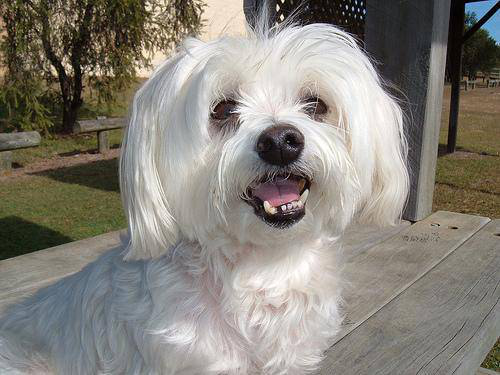

In [11]:
datagen = ImageDataGenerator(
        rotation_range=50,
        width_shift_range=0.32,
        height_shift_range=0.23,
        shear_range=0.32,
        zoom_range=0.33,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('training_images/maltese_dog/1c0d254ae49836d3365bec5e9f663550.jpg') 
img

In [12]:
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

i = 0

if not os.path.exists('preview'):
        os.makedirs('preview')

for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='dog_breed', save_format='jpeg'):
    i += 1
    if i > 30:
        break  # W przeciwnym pzypadku generator będzie działać w nieskonczoność

## Implementacja pierwszej sieci neuronowej
Na początku dokonujemy przekształcenia zbioru testowego. Przeskalowanie to wartość, o którą pomnożymy dane przed jakimkolwiek innym przetwarzaniem. Nasze oryginalne obrazy składają się ze współczynników RGB w zakresie 0–255, ale takie wartości byłyby zbyt wysokie, aby nasz model mógł je przetworzyć (biorąc pod uwagę typowy learning rate), więc zamiast tego celujemy wartości z zakresu od 0 do 1, skalując je z dokładnością 1/255. Z kolei parametr shear_range pozwala przekształcić obraz pod pewnym kątem (bardziej obrazowo - zamiast obrazu w postaci kwadratu otrzymujemy równoległobok), natomiast zoom_range odpowiada za stopień przybliżenia bądź oddalenia obrazka, a horizontal_flip tworzy jego odbicie. Wszystkie te zabiegi mają sprawić, że zbiór treningowy bedzie nieco różnić się od zbioru testowego, by uniknąć nadmiernego dopasowania do danych.


In [13]:
#Train datagen tworzy generator danych testowych
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

#Test_datagen tworzy generator danych walidacyjnych. W tym przypadku jedynie normalizujemy rozmiar zdjęć. 
test_datagen = ImageDataGenerator(rescale=1./255)

Mając stworzone odpowiednie generatory można przystąpić do właśniwego wygenerowania odpowiednich zdjęć. Przekazując parametr class_mode='categorical' unikamy manualanej konwersji etykiet na odpowiednie wektory - generator zrobi to za nas. 

In [14]:
training_set = train_datagen.flow_from_directory(
        'training_images',
        target_size=(128, 128),
        batch_size=20,
        class_mode='categorical')

test_set = test_datagen.flow_from_directory(
        'validation_images',
        target_size=(128, 128),
        batch_size=20,
        class_mode='categorical')

Found 201 images belonging to 4 classes.
Found 474 images belonging to 4 classes.


Majac już przygotowane dane treningowe i testowe możemy przystąpić do tworzenia modelu sieci konwolucyjnej. Wykorzystamy model sekwencyjny (*Sequential*), który jest odpowiedni dla zwykłego stosu warstw, gdzie każda warstwa ma dokładnie jeden tensor wejściowy i jeden tensor wyjściowy. Tego typu model nie sprawdziłby się w przypadku, gdy przykładwo model lub którakolwiek z warstw ma wiele wejść lub wyjść.

Tworzymy pierwszą warstwę, którą dodamy do sieci. Ponieważ dotyczy ona obiektów dwuwymiarowych, wykorzystamy klasę *Conv2D*. Jako parametry w konstruktorze przekazujemy następujace argumenty:   
- **filters** - liczba całkowita, określająca wymiar otrzymany na wyjściu (tj. liczba filtrów wyjściowych w konwolucji).
- **kernel_size** - lista / krotka składająca się z 2 liczb całkowitych, okreslająca rozmiar okna 2D. 
- **input_shape** - ponieważ jest to pierwsza warstwa należy podać wektor wejściowy. W tym przypadku będzie to okno 128x128 px, a przez 3 oznaczamy listę 3 elementów - nasycenie odpowiednich barw w notacji RGB. 
- **activation** - oznacza funkcję aktywacji w danej warstwie. W tym przypadku jest to *rectified linear unit* (ReLU), choć możliwe jest też ustawienie np. funkcji sigmoidalnej lub wykładniczej.  

Warstwa łącząca (*pooling layer*) służy do progresywnej redukcji rozmiaru przestrzennego do zredukowania ilości cech i złożoności obliczeniowej sieci. Najczęściej w sieciach konwolucyjnych stosujemy warstwę MaxPool która przesuwa filtry (tu - 2x2) przez całą macierz wyciągając największą wartość z okna filtra i zapisuje ją do następnej mapy.

Najważniejszy powód stosowania warstw łączących jest uchronienie modelu przed przeuczeniem. Czasami stosujemy też warstwę opuszczającą, która zastępuje warstwę łączącą. Należy być ostrożnym przy stosowaniu warstwy łączącej, szczególnie w zadaniach wizyjnych, gdyż może to spowodować utratę lokalnej wrażliwości modelu mimo zmniejszenia rozmiaru modelu.

Metoda porzucania (*dropout*) to także popularny sposób do walki z przetrenowaniem w przypadku sieci neuronowych. Dropout polega na losowym ustawieniu wychodzących krawędzi ukrytych jednostek (neuronów tworzących ukryte warstwy) na 0 przy każdej aktualizacji fazy treningu.

Metoda ta jest bardzo efektywna, ponieważ co każde przejście losowo wyłączane są połączenia. Dzięki temu sieć neuronowa nie nauczy się „na pamięć” zbyt szybko, ponieważ architektura co przeliczenie odrobinę się zmienia poprzez zerowanie losowych połączeń neuronów.

W Tensorflow dodajemy kolejne warstwy wykorzystując „Dropout” oraz definiując jaka część neuronów ma zostać zapomniana. Np. dla wartości 0.2 zostanie wylosowanych 20% połączeń do wyzerowania. 

Poniższą sieć puściliśmy kilkukrotnie z różnymi parametrami porzucania (przykładowy wykres otrzymanej wartości *loss* będzie można zobaczyć na jednym z wykresów), jednak w ramach eksperymentu tym razem uruchomimy sieć bez porzucania.   

In [15]:
clf = Sequential()
clf.add(Conv2D(32,(2,2),input_shape=(128,128,3),activation='relu'))   
clf.add(MaxPooling2D(pool_size=(2,2)))  
#clf.add(Dropout(0.15))

clf.add(Conv2D(64,(2,2), activation='relu'))
clf.add(MaxPooling2D(pool_size=(2,2)))
#clf.add(Dropout(0.2))

clf.add(Conv2D(128,(2,2), activation='relu'))
clf.add(MaxPooling2D(pool_size=(2,2)))
#clf.add(Dropout(0.2))

clf.add(Conv2D(64,(2,2), activation='relu'))
clf.add(MaxPooling2D(pool_size=(2,2)))
#clf.add(Dropout(0.15))

clf.add(Flatten())
        
clf.add(Dense(units=64,activation='relu'))
#clf.add(Dropout(0.2))

clf.add(Dense(units=4,activation='softmax'))

clf.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

W tym modelu zastosowaliśmy metodę wczesnego zakończenia (*early stopping*). Polega na tym, by zakończyć uczenie, gdy strata na zbiorze testowym nie rośnie - czyli trenując dalej sieć nie poprawiamy mocy modelu na zbiorze testowym. 

W Tensorflow mamy do dyspozycji funkcję EarlyStopping, która monitoruje stratę na zbiorze testowym po zakończeniu każdej epoki. Jeśli strata nie maleje, wówczas trening sieci zostaje zatrzymany. Można zdefiniować 3 podstawowe parametry ustawiając early stopping:

- **monitor** – definiujemy, co chcemy monitorować, na podstawie czego zatrzymamy proces uczenia,
- **patience** – tym parametrem definiujemy liczbę epok po ilu zatrzyma się nasz model jeśli nie zaobserwujemy zmniejszania się funkcji straty,
- **verbose** – w jaki sposób będzie wyświetlana informacja o early stoping.

W naszym modelu skonfigurujemy tylko parametr patience, resztę pozostawiamy domyślnie. 

In [16]:
early_stopping_monitor=EarlyStopping(patience=7)

Uruchamiamy metodę *fit*. *Keras.fit()* oraz *keras.fit_generator()* stanowią dwie odrębne biblioteki do głębokiego uczenia maszynowego, które mogą być wykorzystane do trenowania zarówno modeli machine learningowych jak i deep learningowych. Obie funkcje wykonują to samo, natomiast z uwagi na to, że *fit_generator* jest już przestarzała, wykorzystamy tę pierwszą metodę.

Wykorzystana przez nas metoda przyjmuje następujące parametry:
- **training_set** - zbiór treningowy
- **steps_per_epoch** - to liczba iteracji wsadowych (*batch iterations*), zanim epoka zostanie uznana za zakończoną. Jeśli mamy zestaw treningowy o ustalonym rozmiarze, można go zignorować, ale może być przydatny, jeśli mamy duży zestaw danych lub generujemy losowe rozszerzenia danych.
- **batch_size** - wielkość próbki danych (batch). Określa liczbę próbek w każdej mini partii.
- **validation_steps** - parametr podobny do steps_per_epoch, ale ma zastosowanie w zestawie danych walidacyjnych zamiast w danych szkoleniowych.

In [17]:
hist=clf.fit(
        training_set,
        steps_per_epoch=len(training_set), 
        validation_steps=len(test_set),
        epochs=70,
        validation_data=test_set,
        callbacks=[early_stopping_monitor])

Epoch 1/70
11/11 [==============================] - 9s 776ms/step - loss: 1.3934 - accuracy: 0.3035 - val_loss: 1.3795 - val_accuracy: 0.2785
Epoch 2/70
11/11 [==============================] - 13s 1s/step - loss: 1.3906 - accuracy: 0.2836 - val_loss: 1.3818 - val_accuracy: 0.3228
Epoch 3/70
11/11 [==============================] - 10s 931ms/step - loss: 1.3723 - accuracy: 0.3134 - val_loss: 1.3659 - val_accuracy: 0.3038
Epoch 4/70
11/11 [==============================] - 10s 926ms/step - loss: 1.3452 - accuracy: 0.4527 - val_loss: 1.3937 - val_accuracy: 0.2954
Epoch 5/70
11/11 [==============================] - 10s 885ms/step - loss: 1.3099 - accuracy: 0.3930 - val_loss: 1.2613 - val_accuracy: 0.3924
Epoch 6/70
11/11 [==============================] - 10s 931ms/step - loss: 1.1361 - accuracy: 0.4925 - val_loss: 1.3415 - val_accuracy: 0.3755
Epoch 7/70
11/11 [==============================] - 10s 907ms/step - loss: 1.1810 - accuracy: 0.4627 - val_loss: 1.1438 - val_accuracy: 0.5042
Epo

Mając wytrenowany model możemy go przetestować. W tym celu najpierw normalizujemy rozmiar zdjęć, a następnie wykorzystując metodę *predict* stosujemy nasz model do klasyfikacji danych testowych.   

In [24]:
test_set = []
test_set_ids = []
for curImage in os.listdir('test'):
    test_set_ids.append(os.path.splitext(curImage)[0])
    curImage = cv2.imread('test/'+curImage)
    test_set.append(cv2.resize(curImage,(128, 128)))

In [25]:
test_set = np.array(test_set, np.float32)/255.0

In [26]:
predictions = clf.predict(test_set)

In [27]:
predictions[0].shape

(4,)

Poniżej lista poszczególnych ras wraz z przypisanymi id.

In [28]:
training_set.class_indices

{'afghan_hound': 0,
 'entlebucher': 1,
 'maltese_dog': 2,
 'scottish_deerhound': 3}

In [29]:
classes = {index:breed for breed,index in training_set.class_indices.items()}
column_names = [classes[i] for i in range(4)]

Dla każdego ze zdjęć otrzymaliśmy prawdopodobieństwo przynależności do każdej z ras. "Wygrywa" ta, dla której wartość jest największa.

In [30]:
predictions_df = pd.DataFrame(predictions)
predictions_df.columns = column_names
predictions_df.insert(0,'id', test_set_ids)
predictions_df

,id,afghan_hound,entlebucher,maltese_dog,scottish_deerhound
0,264833ebf9f2bf8b07651f72916f8c75,0.303360,0.504073,3.083268e-03,0.189483
1,ae2b2271318cc84364931ada1c75b295,0.368480,0.001309,5.089397e-01,0.121271
2,35d9bcc10f2762ed900f7a2c48d37c15,0.344226,0.551714,6.289787e-05,0.103997
3,66fabb7f526d842a06829a770b959b9d,0.113165,0.824308,1.936115e-02,0.043166
4,cf5b51fe08e3337217fca120a03ac993,0.080302,0.878270,1.684513e-05,0.041411
...,...,...,...,...,...
10352,5dac8f13467994de6ba778df1cdba3fd,0.000256,0.999128,9.028471e-07,0.000615
10353,4064e9fe3249051177c27d4d505c1d83,0.650737,0.021429,1.414921e-01,0.186341
10354,a9fa08dfaec85e98387911dd4364ce79,0.096058,0.707916,1.605891e-03,0.194420
10355,3be602e5b58c0274b72ad5322d3c8601,0.897553,0.068073,9.206304e-04,0.033454


Wyniki zapisujemy do pliku CSV. 

In [31]:
predictions_df.to_csv('results_1.csv',sep=",")

## Graficzna prezentacja wyników

Poniższy wykres przedstawia stratę (*loss*) na zbiorze walidacyjnym. Im niższa strata, tym lepszy model (chyba że model zbytnio dopasował się do danych treningowych). Stratę oblicza się na podstawie zbioru treningowego i walidacyjnego, a jego interperacja określa, jak dobrze model radzi sobie na tych dwóch zestawach. W przeciwieństwie do dokładności (*accuracy*), strata nie jest wyrażana jako procent. Jest to suma błędów popełnianych dla każdego przykładu w zestawach szkoleniowych lub walidacyjnych.

W przypadku sieci neuronowych strata jest zwykle ujemnym logarytmem wiarygodności i suma kwadratów reszt odpowiednio dla klasyfikacji i regresji. Następnie oczywiście głównym celem w modelu uczenia się jest zmniejszenie (minimalizacja) wartości funkcji straty w odniesieniu do parametrów modelu przez zmianę wartości wag wektora za pomocą różnych metod optymalizacji, takich jak propagacja wsteczna w sieciach neuronowych.

Wartość straty informuje, jak dobrze lub źle zachowuje się określony model po każdej iteracji optymalizacji. Idealnie byłoby oczekiwać zmniejszenia straty po każdej lub kilku iteracjach.

Analizując poniższy wykres widać, że generalnie strata malała wraz z każdą epoką (poza jednym wyjątkowym skokiem). Widać tendencję malejącą i można założyć, że w przypadku zwiększenia zbioru, wykres mógłby się wygładzić.   

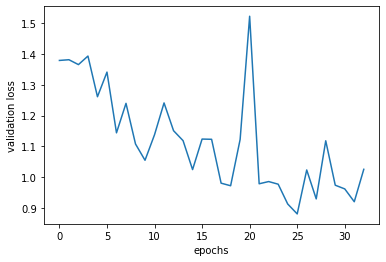

In [32]:
plt.plot(hist.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('validation loss')
plt.show()

Dokładność modelu jest zwykle określana po poznaniu i ustaleniu parametrów modelu i braku daleszej poprawy w uczenia się. Następnie dane testowe są podawane do modelu i rejestrowana jest liczba błędów (klasyfikacja zero-jedynkowa), które popełnił model, po porównaniu z oznaczeniami. Następnie obliczany jest odsetek błędnej klasyfikacji.

Na przykład, jeśli liczba próbek testowych wynosi 1000, a model poprawnie klasyfikuje 952 próbki, to dokładność modelu wynosi 95,2%.

W naszym przypadku w najlepszym momencie udało nam się osiągnąć około 80%, co można uznać za całkiem niezły rezultat.

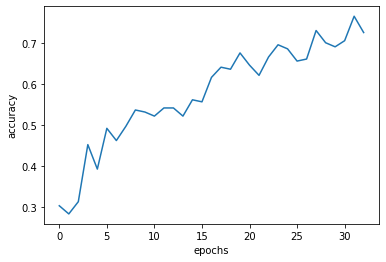

In [33]:
plt.plot(hist.history['accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

Poniżej znajduje się porównanie dokładności modelu na zbiorze testowym i treningowym. Do pewnego momentu można zauważyć, że wyniki dla zbioru testowego i treningowego idą bardzo blisko siebie. Jednakże od około 25 epoki widać że wykresy zaczynają się rozchodzić, co sugeruje, że model staje się przeuczony. 

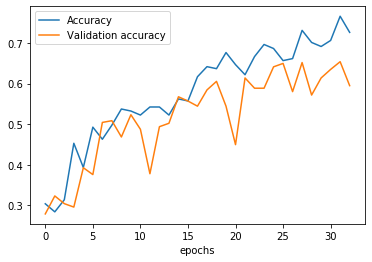

In [34]:
plt.plot(hist.history['accuracy'],label="Accuracy")
plt.plot(hist.history['val_accuracy'], label="Validation accuracy")
plt.legend()
plt.xlabel('epochs')
plt.show()

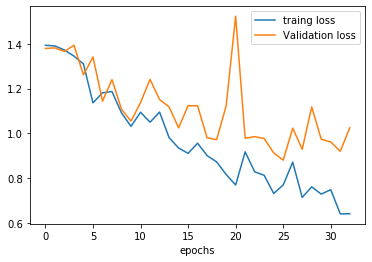

In [35]:
plt.plot(hist.history['loss'],label="traing loss")
plt.plot(hist.history['val_loss'], label="Validation loss")
plt.legend()
plt.xlabel('epochs')
plt.show()

## Wersja #2 - bardziej skomplikowany model
W ramach strojenia parametrów sprawdzimy alternatywną wersję sieci. Tym razem dodaliśmy jeszcze jedną warstwę, a dla pozostałych, z uwagi na ryzyko przetrenowania, podnieśliśmy Dropout. Ponadto zwiększyliśmy rozmiar zamki z 2x2 na 3x3 px. 

In [27]:
clf = Sequential()
clf.add(Conv2D(32,(3,3),input_shape=(128,128,3),activation='relu'))   
clf.add(MaxPooling2D(pool_size=(2,2)))  
clf.add(Dropout(0.1))

clf.add(Conv2D(64,(3,3), activation='relu'))
clf.add(MaxPooling2D(pool_size=(2,2)))
clf.add(Dropout(0.15))

clf.add(Conv2D(128,(3,3), activation='relu'))
clf.add(MaxPooling2D(pool_size=(2,2)))

clf.add(Conv2D(256,(3,3), activation='relu'))
clf.add(MaxPooling2D(pool_size=(2,2)))
clf.add(Dropout(0.15))


clf.add(Conv2D(128,(3,3), activation='relu'))
clf.add(MaxPooling2D(pool_size=(2,2)))
clf.add(Dropout(0.2))

clf.add(Flatten())
        
clf.add(Dense(units=64,activation='relu'))
clf.add(Dropout(0.2))

clf.add(Dense(units=4,activation='softmax'))

clf.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

Podnosimy "cierpliwość" na błędy do 20 epok:

In [28]:
early_stopping_monitor=EarlyStopping(patience=20)

W poprzednim kroku ustaliliśmy liczbę kroków na epokę jako długość zbioru treningowego, a więc wartość 70. Teraz podniesiemy ją dwukrotnie, tak samo jak wartość zmiennej validation_steps. Ustalimy też liczbę epok na 120. 

In [29]:
hist=clf.fit(
        training_set,
        steps_per_epoch=3*len(training_set), 
        validation_steps=3*len(test_set),
        epochs=120,
        validation_data=test_set,
        callbacks=[early_stopping_monitor])

Epoch 1/120
33/33 [==============================] - 39s 1s/step - loss: 1.3979 - accuracy: 0.2753 - val_loss: 1.3850 - val_accuracy: 0.2447
Epoch 2/120
33/33 [==============================] - 35s 1s/step - loss: 1.3764 - accuracy: 0.3051 - val_loss: 1.3576 - val_accuracy: 0.3755
Epoch 3/120
33/33 [==============================] - 34s 1s/step - loss: 1.3319 - accuracy: 0.3582 - val_loss: 1.3123 - val_accuracy: 0.2869
Epoch 4/120
33/33 [==============================] - 36s 1s/step - loss: 1.2397 - accuracy: 0.4577 - val_loss: 1.3021 - val_accuracy: 0.4023
Epoch 5/120
33/33 [==============================] - 34s 1s/step - loss: 1.3375 - accuracy: 0.4163 - val_loss: 1.2466 - val_accuracy: 0.4466
Epoch 6/120
33/33 [==============================] - 35s 1s/step - loss: 1.1757 - accuracy: 0.4793 - val_loss: 1.1050 - val_accuracy: 0.4747
Epoch 7/120
33/33 [==============================] - 35s 1s/step - loss: 1.2299 - accuracy: 0.4362 - val_loss: 1.2566 - val_accuracy: 0.4648
Epoch 8/120
3

Ponownie testujemy nasz model. 

In [30]:
test_set = []
test_set_ids = []
for curImage in os.listdir('test'):
    test_set_ids.append(os.path.splitext(curImage)[0])
    curImage = cv2.imread('test/'+curImage)
    test_set.append(cv2.resize(curImage,(128, 128)))

In [31]:
test_set = np.array(test_set, np.float32)/255.0

In [32]:
predictions = clf.predict(test_set)

In [33]:
predictions[0].shape

(4,)

In [35]:
classes= {index:breed for breed,index in training_set.class_indices.items()}
column_names = [classes[i] for i in range(4)]

Dla każdego ze zdjęć raz jeszcze otrzymujemy prawdopodobienstwo przynależności do każdej z ras na innym zbiorze testowym.

In [36]:
predictions_df = pd.DataFrame(predictions)
predictions_df.columns = column_names
predictions_df.insert(0,'id', test_set_ids)
predictions_df

,id,afghan_hound,entlebucher,maltese_dog,scottish_deerhound
0,264833ebf9f2bf8b07651f72916f8c75,0.073045,7.165420e-01,0.001183,0.209230
1,ae2b2271318cc84364931ada1c75b295,0.453149,1.492538e-07,0.138205,0.408646
2,35d9bcc10f2762ed900f7a2c48d37c15,0.223731,6.242896e-01,0.000176,0.151803
3,66fabb7f526d842a06829a770b959b9d,0.217123,2.982114e-01,0.041676,0.442990
4,cf5b51fe08e3337217fca120a03ac993,0.180777,6.762065e-01,0.000003,0.143014
...,...,...,...,...,...
10352,5dac8f13467994de6ba778df1cdba3fd,0.034084,9.083015e-01,0.000004,0.057610
10353,4064e9fe3249051177c27d4d505c1d83,0.251908,2.245344e-03,0.407789,0.338058
10354,a9fa08dfaec85e98387911dd4364ce79,0.132040,6.912083e-01,0.000319,0.176433
10355,3be602e5b58c0274b72ad5322d3c8601,0.251646,4.701280e-01,0.016661,0.261565


Wyniki zapisujemy do pliku CSV. 

In [37]:
predictions_df.to_csv('results_2.csv',sep=",")

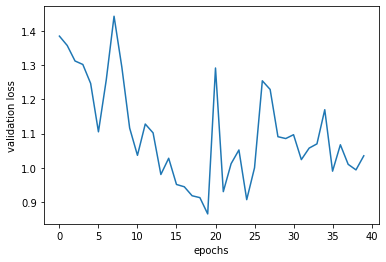

In [38]:
plt.plot(hist.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('validation loss')
plt.show()

Porównując ten i poprzedni model widać, że wskaźnik loss na zbiorze testowym opada znacznie mniej stablilnie - wartośc parametrów skacze zdecydowanie bardziej niż w przypadku pierwszego modelu. Prawdopodobie jest to spowodowane tym, że wykorzystując metodę *dropuot* czyścimy część wyuczonych wartości. Jeśli akurat zdarzy się, że wyzerowaliśmy najlepiej wyuczone neurony, to naturalnym jest, że obiża się jakość całego modelu. Z  drugiej strony, dajemy tym samy innym neuronom szansę na poprawienie swoich wyników.     

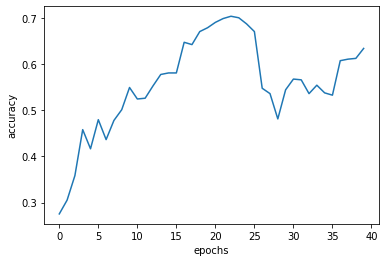

In [39]:
plt.plot(hist.history['accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

Poniżej znajduje się porównanie dokładności modelu na zbiorze testowym i treningowym. Jak widać, dokładność na zbiorze walidacyjnym nie odbiega zbytnio od dokładności na zbiorze treningowym, a więc model nie jest przeuczony. Martwić może natomiast fakt, że sieć osiągnęła niską precyzję, ponieważ w nalepszym momencie *accuracy* wyniosło około 70%.  

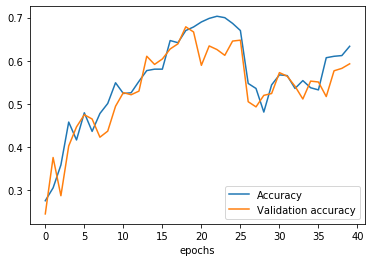

In [40]:
plt.plot(hist.history['accuracy'],label="Accuracy")
plt.plot(hist.history['val_accuracy'], label="Validation accuracy")
plt.legend()
plt.xlabel('epochs')
plt.show()

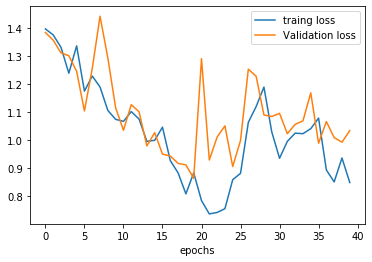

In [41]:
plt.plot(hist.history['loss'],label="traing loss")
plt.plot(hist.history['val_loss'], label="Validation loss")
plt.legend()
plt.xlabel('epochs')
plt.show()

## Wersja #3 - uproszczony model 
Zadaniem tego modelu jest przedstawienie uproszczonej wersji sieci numer #2. Z jednej strony zachowujemy rozmiar okna oraz metodę Dropout (mając w pamięci przeuczenie w pierwszej sieci). Z drugiej jednak zmniejszamy liczbę warstw Conv2D sieci do dwóch, a dla tych, które pozostały, ustalamy wymiar na wyjściu na 64. Tym razem cierpliwość do modelu ustawiamy na 10.   

In [15]:
early_stopping_monitor=EarlyStopping(patience=10)

In [16]:
clf = Sequential()
clf.add(Conv2D(64,(3,3),input_shape=(128,128,3),activation='relu'))   
clf.add(MaxPooling2D(pool_size=(2,2)))  
clf.add(Dropout(0.1))

clf.add(Conv2D(64,(3,3), activation='relu'))
clf.add(MaxPooling2D(pool_size=(2,2)))
clf.add(Dropout(0.1))

clf.add(Flatten())
        
#Adding An ANN
clf.add(Dense(units=64,activation='relu'))
clf.add(Dropout(0.1))

clf.add(Dense(units=4,activation='softmax'))

clf.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [17]:
hist=clf.fit(
        training_set,
        steps_per_epoch=30, 
        validation_steps=30,
        epochs=50,
        validation_data=test_set,
        callbacks=[early_stopping_monitor])

Epoch 1/50
30/30 [==============================] - 25s 821ms/step - loss: 1.5641 - accuracy: 0.2687 - val_loss: 1.3849 - val_accuracy: 0.2744
Epoch 2/50
30/30 [==============================] - 25s 836ms/step - loss: 1.3192 - accuracy: 0.4438 - val_loss: 1.2063 - val_accuracy: 0.4394
Epoch 3/50
30/30 [==============================] - 24s 816ms/step - loss: 1.1430 - accuracy: 0.4807 - val_loss: 1.1770 - val_accuracy: 0.4680
Epoch 4/50
30/30 [==============================] - 26s 858ms/step - loss: 1.0241 - accuracy: 0.5480 - val_loss: 1.1736 - val_accuracy: 0.4898
Epoch 5/50
30/30 [==============================] - 26s 856ms/step - loss: 1.0358 - accuracy: 0.5801 - val_loss: 1.0859 - val_accuracy: 0.5354
Epoch 6/50
30/30 [==============================] - 25s 826ms/step - loss: 0.8587 - accuracy: 0.6556 - val_loss: 1.1603 - val_accuracy: 0.5943
Epoch 7/50
30/30 [==============================] - 25s 827ms/step - loss: 0.7671 - accuracy: 0.7017 - val_loss: 1.1900 - val_accuracy: 0.5204

In [27]:
test_set = []
test_set_ids = []
for curImage in os.listdir('test'):
    test_set_ids.append(os.path.splitext(curImage)[0])
    curImage = cv2.imread('test/'+curImage)
    test_set.append(cv2.resize(curImage,(128, 128)))

In [28]:
test_set = np.array(test_set, np.float32)/255.0

In [29]:
predictions = clf.predict(test_set)

In [30]:
predictions[0].shape

(4,)

In [31]:
classes= {index:breed for breed,index in training_set.class_indices.items()}
column_names = [classes[i] for i in range(4)]

In [32]:
predictions_df = pd.DataFrame(predictions)
predictions_df.columns = column_names
predictions_df.insert(0,'id', test_set_ids)
#predictions_df

Wyniki zapisujemy do pliku CSV. 

In [33]:
predictions_df.to_csv('results_3.csv',sep=",")

Tym razem patrzac na wyniki dla zbioru treningowego możemy stwierdzić, że nasz model osiągnął rewelacyjne rezultaty dla zbioru treningowego - zwłaszcza patrząc na wykres *accuracy*, który osiągnął około 95%.    

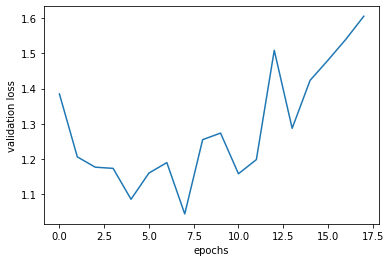

In [34]:
plt.plot(hist.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('validation loss')
plt.show()

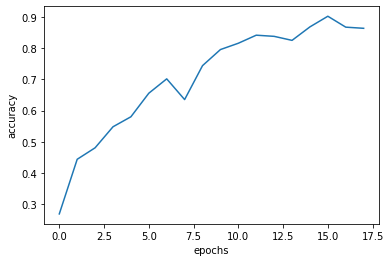

In [35]:
plt.plot(hist.history['accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

Sytuacja wygląda zdecydowanie gorzej, jeśli popatrzymy na wykres dla zbioru walidacyjnego. Widzimy znaczą różnicę w jakości modelu na danych testowych i walidacyjnych. Szczególnie uwypukla to wykres straty, gdzie linia *Validation loss* oscyluje w okolicy wartości 1.0, a *training loss* pikuje niemal do zera.  

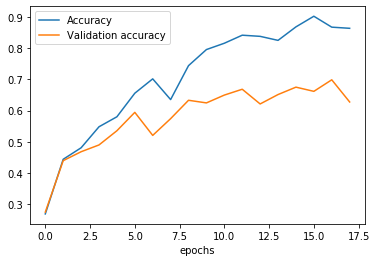

In [36]:
plt.plot(hist.history['accuracy'],label="Accuracy")
plt.plot(hist.history['val_accuracy'], label="Validation accuracy")
plt.legend()
plt.xlabel('epochs')
plt.show()

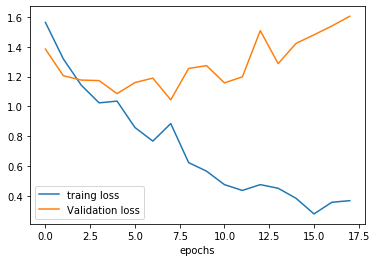

In [37]:
plt.plot(hist.history['loss'],label="traing loss")
plt.plot(hist.history['val_loss'], label="Validation loss")
plt.legend()
plt.xlabel('epochs')
plt.show()

## Wersja #4 - model #3 z podniesioną wartością dropout  
Zadaniem tego modelu jest usunięcie przeuczenia z modelu #3. Dokonamy tego podnosząc wartości Droput do poziomu 0,2 a cierplowość do modelu ustalamy na 5.

In [15]:
early_stopping_monitor=EarlyStopping(patience=5)

In [16]:
clf = Sequential()
clf.add(Conv2D(64,(3,3),input_shape=(128,128,3),activation='relu'))   
clf.add(MaxPooling2D(pool_size=(2,2)))  
clf.add(Dropout(0.45))

clf.add(Conv2D(64,(3,3), activation='relu'))
clf.add(MaxPooling2D(pool_size=(2,2)))
clf.add(Dropout(0.45))

clf.add(Flatten())
        
#Adding An ANN
clf.add(Dense(units=64,activation='relu'))
clf.add(Dropout(0.45))

clf.add(Dense(units=4,activation='softmax'))

clf.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [17]:
hist=clf.fit(
        training_set,
        steps_per_epoch=30, 
        validation_steps=30,
        epochs=50,
        validation_data=test_set,
        callbacks=[early_stopping_monitor])

Epoch 1/50
30/30 [==============================] - 23s 756ms/step - loss: 1.8292 - accuracy: 0.2527 - val_loss: 1.3865 - val_accuracy: 0.2441
Epoch 2/50
30/30 [==============================] - 27s 899ms/step - loss: 1.3835 - accuracy: 0.3112 - val_loss: 1.3850 - val_accuracy: 0.2626
Epoch 3/50
30/30 [==============================] - 27s 887ms/step - loss: 1.3868 - accuracy: 0.2891 - val_loss: 1.3865 - val_accuracy: 0.2475
Epoch 4/50
30/30 [==============================] - 26s 873ms/step - loss: 1.3756 - accuracy: 0.2954 - val_loss: 1.3772 - val_accuracy: 0.2415
Epoch 5/50
30/30 [==============================] - 27s 890ms/step - loss: 1.3597 - accuracy: 0.3370 - val_loss: 1.3787 - val_accuracy: 0.3737
Epoch 6/50
30/30 [==============================] - 26s 870ms/step - loss: 1.3272 - accuracy: 0.3591 - val_loss: 1.2942 - val_accuracy: 0.3805
Epoch 7/50
30/30 [==============================] - 26s 879ms/step - loss: 1.2226 - accuracy: 0.4383 - val_loss: 1.1833 - val_accuracy: 0.4490

In [18]:
test_set = []
test_set_ids = []
for curImage in os.listdir('test'):
    test_set_ids.append(os.path.splitext(curImage)[0])
    curImage = cv2.imread('test/'+curImage)
    test_set.append(cv2.resize(curImage,(128, 128)))

In [19]:
test_set = np.array(test_set, np.float32)/255.0

In [20]:
predictions = clf.predict(test_set)

In [21]:
predictions[0].shape

(4,)

In [22]:
classes = {index:breed for breed,index in training_set.class_indices.items()}
column_names = [classes[i] for i in range(4)]

In [23]:
predictions_df = pd.DataFrame(predictions)
predictions_df.columns = column_names
predictions_df.insert(0,'id', test_set_ids)
#predictions_df

In [24]:
predictions_df.to_csv('results_4.csv',sep=",")

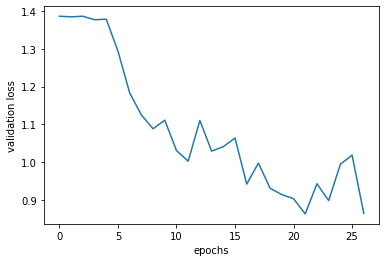

In [25]:
plt.plot(hist.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('validation loss')
plt.show()

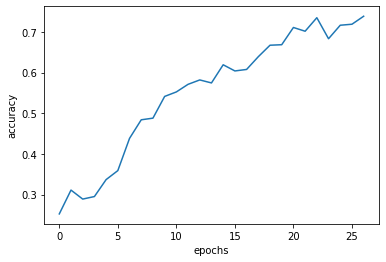

In [26]:
plt.plot(hist.history['accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

Jak widać jakość naszego modelu zdecydowanie się poprawiła. Co prawda osiągnęliśmy to kosztem gorszych rezultatów dla zbioru treningowego - maksymalna osiągnięta wartość *accuracy* wynosi ponad 0.7, podczas gdy dla poprzedniego modelu osiągaliśmy wyniki nawet ponad 90%. Z drugiej strony udało nam się bardzo mocno "zbić" przeuczenie przy zachowaniu stabliności modelu - linie dla *accuracy* oraz *loss* na zbiorze treningowym i walidacyjnym niemal się pokrywają, a do tego ich kształ jest zbliżony do wykresu liniowego.   

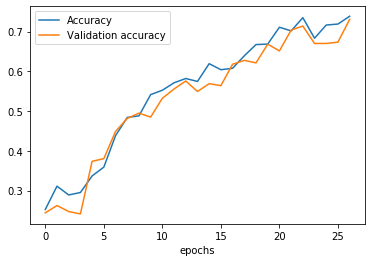

In [27]:
plt.plot(hist.history['accuracy'],label="Accuracy")
plt.plot(hist.history['val_accuracy'], label="Validation accuracy")
plt.legend()
plt.xlabel('epochs')
plt.show()

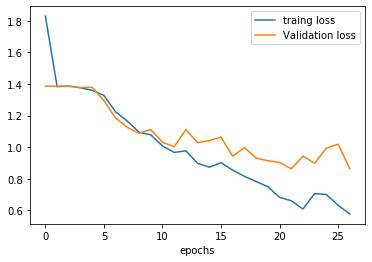

In [28]:
plt.plot(hist.history['loss'],label="traing loss")
plt.plot(hist.history['val_loss'], label="Validation loss")
plt.legend()
plt.xlabel('epochs')
plt.show()

## Podsumowanie

Tak jak zostało to opisane we wprowadzeniu na podstawie zdjęć psów, z wykorzystaiem uczenia sieci neuronowej przypisaliśmy ich rasy. Proces uczenia sieci wykonaliśmy poprzez Konwulacyjną (Splotową) sieć neuronową ze względu na jej efektywniejsze działanie nie wykorzystujące dużej ilości parametrów.
Podzieliliśmy zbiory na testowy ( w tym treningowy)  i walidacyjny, następnie załadowaliśmy odpowiednią proporcjonalną ilość zdjęć. Dokonaliśmy prób uczących przez sieć z wykorzystaniem biblioteki KERAS.
Proces wyglądał następująco:

- Na wejściu algorytm otrzymuje zbiór zawierający N obrazów, każdy z nich przypisany jest do jednej z K klas. 
- Następnie wykorzystuje się zbiór treningowy do szkolenia klasyfikatora tak, aby był on w stanie jak najepiej przyporządkować etykietę do zdjęcia.
- Na koniec ocenia się jakość klasyfikatora, prosząc go o przewidywanie etykiet dla nowego zestawu obrazów, których nigdy wcześniej nie widział, po czym porównamy prawdziwe etykiety tych obrazów z przewidywanymi przez klasyfikator.

Po przetworzeniu procesów otrzymaliśmy wyniki:
- Dla sieci #1 liczba warstw wydaje się być bliska odpowiedniej, natomiast brak brak ustalonych wartości Dropout spowodował, że w pewnym momencie sieć zaczeła być podatna na przeuczenie 
- Model #2 okazał się być zbyt skomplikowany, przez co model nie mógł przebić się przez *accuracy* powyżej 0,7. Z drugiej strony, odpowiednio skalibrowane odrzucanie spowodowało, że wartości dla zbioru walidacyjnego nie odbiegają od tych dla treningowego.
- W modelu #3 udało nam się osiągnąć najlepsze rezultaty dla zbioru treningowego. Niskie wartości dla warstwy odrzucającej spowodowały jednak przeuczenie.
- Model #4 okazuje się być najlepszym, jaki udało nam się osiągnąć. Łączy on zalety wszystkich pozostałych trzech modeli. Jego architektura jest relatywnie prosta w porównaniu z #1 oraz #2, co skutkuje niską zmiennością w kontekście nauki modelu. Z drugiej jednak strony wyeliminowaliśmy przeuczenie, występujące w sieci #3.

Jednym problemem, z którym nie udało nam się poradzić, to "przebicie" granicy 0.8 dokładności przy zachowaniu osiągniętej stabilności oraz niskiego przeuczenia. Z drugiej jednak strony, może to być wina małego zbioru danych na którym pracowaliśmy (w końcu z pośród 10 tysięcy zdjęć zostawiliśmy raptem niecałe 500). Wymagałoby to jednak ręcznego powiększenia bazy fotografii dla odpowiednich ras psów bądź też wykorzystania narzędzi do Web Scrapingu, by zautomatyzować ten proces. 

## Bibliografia
- http://home.agh.edu.pl/~horzyk/lectures/ai/SztucznaInteligencja-UczenieG%C5%82%C4%99bokichSieciNeuronowych.pdf
- https://keras.io/api/
- https://miroslawmamczur.pl/przykladowa-siec-neuronowa-mlp-w-tensorflow/
- https://ksopyla.com/python/tensorflow/wielowarstwowa-siec-neuronowa-w-tensorflow-do-klasyfikacji-cyfr-z-mnist/
- https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33